# Evaluation Notebook (Modelo base, DreamerMix, GAE-VTrace, PPO)

## 1. Setup and Dependencies

In [ ]:
import os
import sys
import yaml
from pathlib import Path
from datetime import datetime
import imageio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import mlflow
from mlflow.tracking import MlflowClient

sys.path.insert(0, str(Path('../../').absolute()))

from pydreamer import tools
from pydreamer.envs import create_env
from pydreamer.models import *
from pydreamer.preprocessing import Preprocessor

# Configure plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Setup MLflow
mlruns_path = Path('../../mlruns/0')

ACTION_REPEAT = 4  # Para Atari

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")

MLflow tracking URI: file:///home/henriquesouza/IA367/IA367-pydreamer/results/atari/mlruns


## 2. Configurações de ambiente

In [25]:
CONFIG = {
    'env_id': 'Atari-Pong',
    'env_action_repeat': 4,
    'env_time_limit': 0,
    'env_no_terminal': False,
    'seed': 42,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'video_fps': 10,
    'results_dir': './evaluation_results',
}

# Agent types to evaluate
AGENT_TYPES = ['dreamerv2_base', 'dreamermix', 'gae_vtrace', 'ppo']

# Create results directory
Path(CONFIG['results_dir']).mkdir(exist_ok=True, parents=True)

print(f"Environment: {CONFIG['env_id']}")
print(f"Device: {CONFIG['device']}")
print(f"Results directory: {CONFIG['results_dir']}")

Environment: Atari-Pong
Device: cuda
Results directory: ./evaluation_results


## 3. Exportar Runs

In [26]:
MANUAL_RUN_MAPPING = {
    'dreamerv2_base': '58d45ccf5a334b369cc2c57fc834332a',
    'dreamermix': 'af29dc230aa844bdbf90d1659a917b9e',
    'gae_vtrace': '403e7e0fae6141f78663f6dbc5d4663f',
    'ppo': 'a2edb9ea819e43188852488f530a3bfb',
}

### 3.1 Buscar Runs

In [27]:
# Buscar runs manualmente através do sistema de arquivos

# Listar todos os diretórios de runs
run_dirs = [d for d in mlruns_path.iterdir() if d.is_dir() and d.name != 'meta.yaml']
runs_data = []

print(f"Encontrados {len(run_dirs)} runs no experimento 0\n")

# Para cada run, ler as informações básicas
for idx, run_dir in enumerate(sorted(run_dirs), 1):
    run_id = run_dir.name
    
    # Ler meta.yaml do run
    meta_file = run_dir / 'meta.yaml'
    
    if meta_file.exists():
        with open(meta_file, 'r') as f:
            meta = yaml.safe_load(f)
        
        # Ler params
        params = {}
        params_dir = run_dir / 'params'
        if params_dir.exists():
            for param_file in params_dir.iterdir():
                if param_file.is_file():
                    with open(param_file, 'r') as f:
                        params[param_file.name] = f.read().strip()
        
        # Converter timestamp para data legível
        start_time_ms = meta.get('start_time', 0)
        if start_time_ms:
            start_time_dt = datetime.fromtimestamp(start_time_ms / 1000)
            start_time_str = start_time_dt.strftime('%Y-%m-%d %H:%M:%S')
        else:
            start_time_str = 'N/A'

        # Mapear experimentos
        experiment_name = 'N/A'
        for exp, code in MANUAL_RUN_MAPPING.items():
            if run_id == code:
                experiment_name = exp
                break

        runs_data.append({
            'experiment': experiment_name,
            'run_id': run_id,
            'status': meta.get('lifecycle_stage', 'N/A'),
            'start_time': start_time_dt,
            'start_time_str': start_time_str,
            'env_id': params.get('env_id', 'N/A'),
            'params': params
        })
        
        print("*" * 80)

        print(f"Run {idx}/{len(run_dirs)} - run_id: {run_id}")
        print(f"Experiment: {experiment_name}")
        print(f"Status: {meta.get('lifecycle_stage', 'N/A')}")
        print(f"User: {meta.get('user_id', 'N/A')}")
        print(f"Start time: {start_time_str}")
        print(f"Env ID: {params.get('env_id', 'N/A')}")
        print(f"Number of params: {len(params)}")
        print("Params:")
        for k in sorted(params.keys()):
            print(f"  {k}: {params[k]}")
        print()

Encontrados 4 runs no experimento 0

********************************************************************************
Run 1/4 - run_id: 403e7e0fae6141f78663f6dbc5d4663f
Experiment: gae_vtrace
Status: active
User: henriquesouza
Start time: 2025-11-16 15:36:41
Env ID: Atari-Pong
Number of params: 103
Params:
  action_dim: 18
  actor_dist: onehot
  actor_grad: reinforce
  adam_eps: 1e-05
  adam_lr: 0.0003
  adam_lr_actor: 0.0001
  adam_lr_critic: 0.0001
  allow_mid_reset: True
  amp: False
  aux_critic: False
  aux_critic_weight: 1.0
  batch_length: 48
  batch_size: 32
  buffer_size: 10000000
  buffer_size_offline: 0
  clip_rewards: tanh
  cnn_depth: 48
  data_workers: 4
  deter_dim: 1024
  device: cuda:0
  enable_profiler: False
  entropy: 0.001
  env_action_repeat: 4
  env_id: Atari-Pong
  env_id_eval: None
  env_no_terminal: False
  env_time_limit: 27000
  eval_batch_size: 32
  eval_batches: 61
  eval_interval: 2000
  eval_samples: 1
  eval_save_size: 1
  gamma: 0.99
  gamma_aux: 0.99


### 3.2 Funções de Exportação

In [28]:
client = MlflowClient()

# Função para extrair métricas do MLflow manualmente (lendo arquivos)
def read_metric_file(metric_path):
    """Lê um arquivo de métrica do MLflow"""
    data = []
    try:
        with open(metric_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                if len(parts) >= 3:
                    timestamp = int(parts[0])
                    value = float(parts[1])
                    step = int(parts[2])
                    data.append({'timestamp': timestamp, 'value': value, 'step': step})
    except Exception as e:
        print(f"Erro ao ler {metric_path}: {e}")
    return data

def load_metric_from_filesystem(run_dir, metric_name, value_column='y', x_bucket=1):
    """Carrega métrica diretamente do sistema de arquivos"""
    metric_path = run_dir / 'metrics' / metric_name
    
    if not metric_path.exists():
        return pd.DataFrame()
    
    data = read_metric_file(metric_path)
    
    if not data:
        return pd.DataFrame()
    
    df = pd.DataFrame({
        'x': [(d['step'] // x_bucket + 1) * x_bucket for d in data],
        value_column: [d['value'] for d in data],
    })
    
    return df

def load_run_metrics_from_filesystem(run_dir, env_name, run_name, x_bucket=2000):
    """Carrega métricas principais de um run do sistema de arquivos"""
    
    metrics_to_load = {
        'return': 'agent/return',
        'agent_steps': 'train/data_steps',
    }
    
    df = None
    for k, v in metrics_to_load.items():
        df1 = load_metric_from_filesystem(run_dir, v, k, x_bucket)
        if not df1.empty:
            df1 = df1.groupby('x').mean()
            df = df1 if df is None else df.combine_first(df1)
    
    if df is None or df.empty:
        print(f"Nenhuma métrica encontrada para o run {run_name}")
        return None
    
    df = df.reset_index().rename(columns={'x': 'train_steps'})
    
    # Calcular env_steps
    if 'agent_steps' in df.columns:
        df['env_steps'] = df['agent_steps'] * ACTION_REPEAT
    
    # Adicionar metadados
    df['env'] = env_name.lower().replace('-', '_')
    df['run'] = run_name
    
    # Remover linhas sem env_steps
    df = df[~df['env_steps'].isna()]
    
    return df

### 3.3 Exportar todas as runs para CSV

In [29]:
# Criar diretório para salvar os CSVs
runs_output_dir = Path('./runs')
runs_output_dir.mkdir(exist_ok=True)

print(f"Exportando {len(runs_data)} runs...\n")

exported_runs = []

for run_info in runs_data:
    run_id = run_info['run_id']
    experiment_name = run_info['experiment']
    env_id = run_info['env_id']
    
    # Definir nome do arquivo
    if experiment_name != 'N/A':
        run_name = f"{env_id.lower().replace('-', '_')}_{experiment_name}"
    else:
        run_name = f"{env_id.lower().replace('-', '_')}_{run_id[:8]}"
    
    print(f"Processando: {experiment_name} (run_id: {run_id[:8]}...)")
    
    # Carregar métricas do sistema de arquivos
    run_dir = mlruns_path / run_id
    df_metrics = load_run_metrics_from_filesystem(run_dir, env_id, run_name, x_bucket=2000)
    
    if df_metrics is not None and not df_metrics.empty:
        # Salvar CSV
        output_file = runs_output_dir / f'{run_name}.csv'
        df_metrics.round(1).to_csv(output_file, index=False)
        
        exported_runs.append({
            'experiment': experiment_name,
            'run_id': run_id,
            'file': str(output_file),
            'records': len(df_metrics)
        })
        
        print(f"  ✓ Exportado: {output_file.name} ({len(df_metrics)} registros)")
    else:
        print(f"  Sem métricas disponíveis")
    
    print()

print(f"\n{'='*80}")
print(f"Exportação concluída!")
print(f"Total de runs exportados: {len(exported_runs)}/{len(runs_data)}")
print(f"Arquivos salvos em: {runs_output_dir.absolute()}")

# Mostrar resumo
if exported_runs:
    export_df = pd.DataFrame(exported_runs)
    print(f"\nResumo das exportações:")
    print(export_df[['experiment', 'records', 'file']])

Exportando 4 runs...

Processando: gae_vtrace (run_id: 403e7e0f...)
  ✓ Exportado: atari_pong_gae_vtrace.csv (399 registros)

Processando: dreamerv2_base (run_id: 58d45ccf...)
  ✓ Exportado: atari_pong_dreamerv2_base.csv (130 registros)

Processando: ppo (run_id: a2edb9ea...)
  ✓ Exportado: atari_pong_ppo.csv (41 registros)

Processando: dreamermix (run_id: af29dc23...)
  ✓ Exportado: atari_pong_dreamermix.csv (127 registros)


Exportação concluída!
Total de runs exportados: 4/4
Arquivos salvos em: /home/henriquesouza/IA367/IA367-pydreamer/results/atari/runs

Resumo das exportações:
       experiment  records                                file
0      gae_vtrace      399      runs/atari_pong_gae_vtrace.csv
1  dreamerv2_base      130  runs/atari_pong_dreamerv2_base.csv
2             ppo       41             runs/atari_pong_ppo.csv
3      dreamermix      127      runs/atari_pong_dreamermix.csv


### 3.4 Visualizar Preview dos Dados Exportados

In [30]:
for exp_info in exported_runs:
    print(f"\n{'='*80}")
    print(f"Experimento: {exp_info['experiment']}")
    print(f"Arquivo: {exp_info['file']}")
    print(f"Total de registros: {exp_info['records']}")
    print(f"\nPrimeiras linhas:")
    
    df = pd.read_csv(exp_info['file'])
    print(df.head(10))
    
    print(f"\nÚltimas linhas:")
    print(df.tail(5))
    
    # Estatísticas básicas
    if 'return' in df.columns:
        print(f"\nEstatísticas do Return:")
        print(f"  Média: {df['return'].mean():.2f}")
        print(f"  Máximo: {df['return'].max():.2f}")
        print(f"  Mínimo: {df['return'].min():.2f}")
        print(f"  Último valor: {df['return'].iloc[-1]:.2f}")


Experimento: gae_vtrace
Arquivo: runs/atari_pong_gae_vtrace.csv
Total de registros: 399

Primeiras linhas:
   train_steps  agent_steps  return  env_steps         env  \
0         2000    2319654.4   -20.9  9278617.6  atari_pong   
1         4000      84893.0   -20.5   339572.0  atari_pong   
2         6000     125693.0   -20.1   502772.0  atari_pong   
3         8000     162142.0   -17.9   648568.0  atari_pong   
4        10000     200578.0   -15.3   802312.0  atari_pong   
5        12000     238162.5   -14.3   952650.0  atari_pong   
6        14000     275258.5   -14.0  1101034.0  atari_pong   
7        16000     312493.0   -11.7  1249972.0  atari_pong   
8        18000     353293.0   -10.1  1413172.0  atari_pong   
9        20000     387379.0    -4.4  1549516.0  atari_pong   

                     run  
0  atari_pong_gae_vtrace  
1  atari_pong_gae_vtrace  
2  atari_pong_gae_vtrace  
3  atari_pong_gae_vtrace  
4  atari_pong_gae_vtrace  
5  atari_pong_gae_vtrace  
6  atari_pong_gae_vt

## 4. Visualização Comparativa

In [31]:
# Carregar todos os CSVs exportados e consolidar em um único DataFrame
all_data = []

for exp_info in exported_runs:
    df = pd.read_csv(exp_info['file'])
    df['method'] = exp_info['experiment']
    all_data.append(df)

# Concatenar todos os dados
data_consolidated = pd.concat(all_data, ignore_index=True)

print(f"Total de dados consolidados: {len(data_consolidated)} registros")
print(f"\nMétodos disponíveis: {data_consolidated['method'].unique()}")
print(f"Ambientes: {data_consolidated['env'].unique()}")
print(f"\nPreview dos dados:")
print(data_consolidated.head())

Total de dados consolidados: 697 registros

Métodos disponíveis: ['gae_vtrace' 'dreamerv2_base' 'ppo' 'dreamermix']
Ambientes: ['atari_pong']

Preview dos dados:
   train_steps  agent_steps  return  env_steps         env  \
0         2000    2319654.4   -20.9  9278617.6  atari_pong   
1         4000      84893.0   -20.5   339572.0  atari_pong   
2         6000     125693.0   -20.1   502772.0  atari_pong   
3         8000     162142.0   -17.9   648568.0  atari_pong   
4        10000     200578.0   -15.3   802312.0  atari_pong   

                     run      method  
0  atari_pong_gae_vtrace  gae_vtrace  
1  atari_pong_gae_vtrace  gae_vtrace  
2  atari_pong_gae_vtrace  gae_vtrace  
3  atari_pong_gae_vtrace  gae_vtrace  
4  atari_pong_gae_vtrace  gae_vtrace  


### 4.1 Preparar dados para visualização

In [32]:
# Discretizar env_steps para 1M steps
data_consolidated['env_steps_discrete'] = (data_consolidated['env_steps'] / 1e6).apply(np.ceil) * 1e6

# Agrupar por método, ambiente e env_steps
df_grouped = data_consolidated.groupby(['method', 'env', 'env_steps_discrete'])['return'].agg(['mean', 'std', 'count']).reset_index()
df_grouped['std'] = df_grouped['std'].fillna(0)
df_grouped = df_grouped.rename(columns={'mean': 'return_mean', 'std': 'return_std', 'env_steps_discrete': 'env_steps'})

# Calcular média móvel (rolling mean) para suavizar as curvas
window_size = 5  # Janela de 5 pontos
df_plot = []

for method in df_grouped['method'].unique():
    df_method = df_grouped[df_grouped['method'] == method].sort_values('env_steps')
    
    # Aplicar média móvel
    df_method['return_smooth'] = df_method['return_mean'].rolling(window=window_size, center=True, min_periods=1).mean()
    df_method['return_std_smooth'] = df_method['return_std'].rolling(window=window_size, center=True, min_periods=1).mean()
    
    df_plot.append(df_method)

df_plot = pd.concat(df_plot, ignore_index=True)

print("Dados preparados para visualização:")
print(df_plot.head(20))
print(f"\nMétodos: {df_plot['method'].unique()}")
print(f"Range de env_steps: {df_plot['env_steps'].min()/1e6:.1f}M - {df_plot['env_steps'].max()/1e6:.1f}M")

Dados preparados para visualização:
        method         env   env_steps  return_mean  return_std  count  \
0   dreamermix  atari_pong   1000000.0   -16.483333    4.162892      6   
1   dreamermix  atari_pong   2000000.0    -7.266667    1.207753      6   
2   dreamermix  atari_pong   3000000.0    -2.450000    2.453365      6   
3   dreamermix  atari_pong   4000000.0     8.928571    2.771109      7   
4   dreamermix  atari_pong   5000000.0    16.000000    0.940213      6   
5   dreamermix  atari_pong   6000000.0    18.033333    1.105743      6   
6   dreamermix  atari_pong   7000000.0    18.366667    0.350238      6   
7   dreamermix  atari_pong   8000000.0    18.628571    0.368394      7   
8   dreamermix  atari_pong   9000000.0    19.000000    0.641872      6   
9   dreamermix  atari_pong  10000000.0    19.128571    0.377334      7   
10  dreamermix  atari_pong  11000000.0    19.266667    0.366970      6   
11  dreamermix  atari_pong  12000000.0    19.628571    0.407080      7   
12

### 4.2 Gráfico Comparativo de Todas as Runs

Figura salva em: figs/comparison_all_methods.png


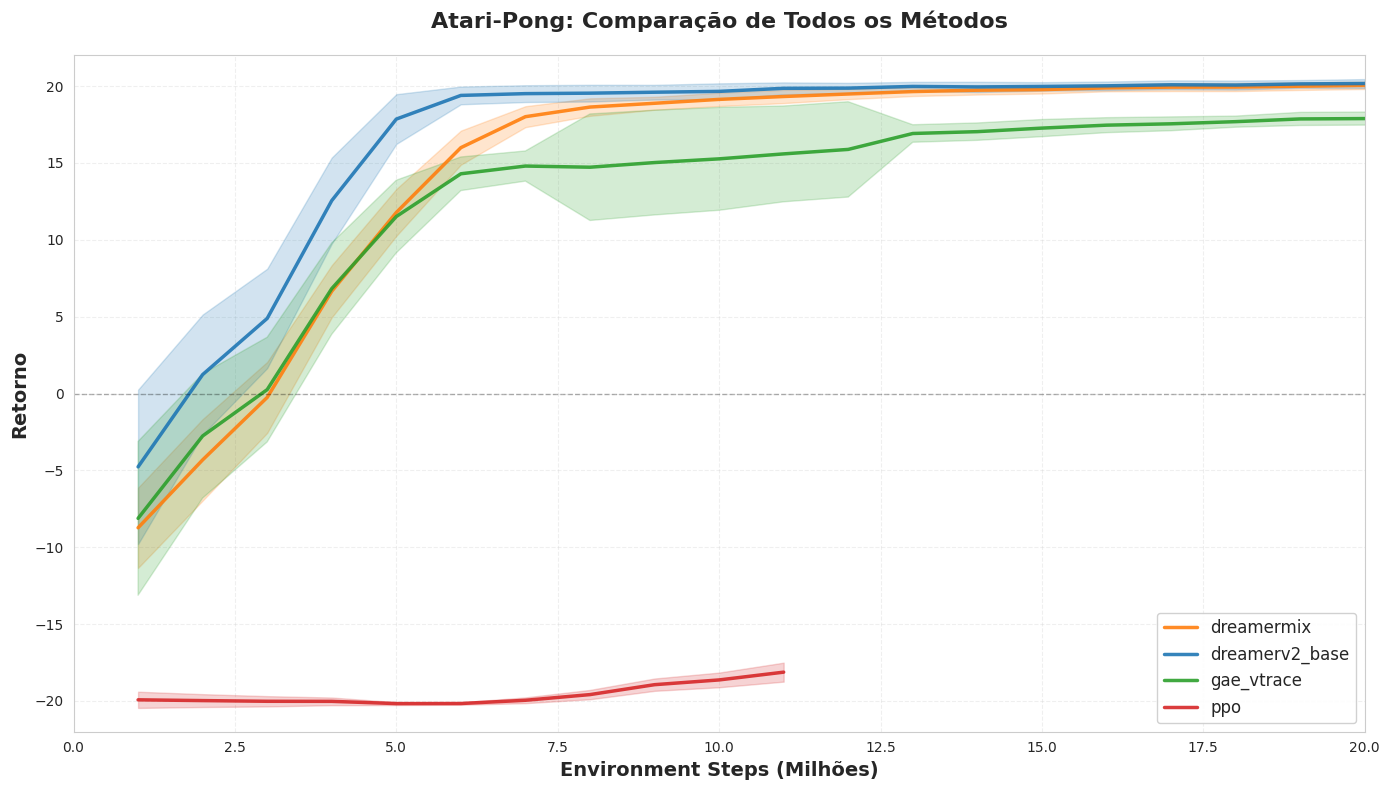

In [34]:
# Criar diretório para salvar figuras
figs_dir = Path('./figs')
figs_dir.mkdir(exist_ok=True)

# Configurar cores para cada método
colors = {
    'dreamerv2_base': '#1f77b4',  # Azul
    'dreamermix': '#ff7f0e',      # Laranja
    'gae_vtrace': '#2ca02c',      # Verde
    'ppo': '#d62728',              # Vermelho
}

# Criar figura com tamanho maior
fig, ax = plt.subplots(figsize=(14, 8))

# Plotar cada método
for method in df_plot['method'].unique():
    df_method = df_plot[df_plot['method'] == method].sort_values('env_steps')
    
    color = colors.get(method, None)
    
    # Linha principal (média móvel)
    ax.plot(df_method['env_steps'] / 1e6, 
            df_method['return_smooth'], 
            label=method, 
            linewidth=2.5,
            color=color,
            alpha=0.9)
    
    # Área sombreada (desvio padrão)
    ax.fill_between(df_method['env_steps'] / 1e6,
                     df_method['return_smooth'] - df_method['return_std_smooth'],
                     df_method['return_smooth'] + df_method['return_std_smooth'],
                     alpha=0.2,
                     color=color)

# Configurações do gráfico
ax.set_xlabel('Environment Steps (Milhões)', fontsize=14, fontweight='bold')
ax.set_ylabel('Retorno', fontsize=14, fontweight='bold')
ax.set_title('Atari-Pong: Comparação de Todos os Métodos', fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='lower right', framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(0, 20)
ax.set_ylim(-22, 22)

# Adicionar linha zero para referência
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)

# Melhorar layout
plt.tight_layout()

# Salvar figura
output_file = figs_dir / 'comparison_all_methods.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Figura salva em: {output_file}")

plt.show()

### 4.3 Estatísticas Finais


DREAMERMIX
  Return final: 19.95 ± 0.19
  Return máximo: 20.13
  Return médio: 14.49
  Steps finais: 20.0M

DREAMERV2_BASE
  Return final: 20.12 ± 0.33
  Return máximo: 20.22
  Return médio: 16.11
  Steps finais: 20.0M

GAE_VTRACE
  Return final: 18.72 ± 0.10
  Return máximo: 18.90
  Return médio: 16.20
  Steps finais: 57.0M

PPO
  Return final: -16.95 ± 0.64
  Return máximo: -16.95
  Return médio: -19.54
  Steps finais: 11.0M

RANKING POR RETORNO FINAL

        method  final_return  final_std  max_return  avg_return  final_steps_M
dreamerv2_base     20.116667   0.331160   20.216667   16.114048           20.0
    dreamermix     19.950000   0.187083   20.133333   14.487500           20.0
    gae_vtrace     18.716667   0.098319   18.900000   16.200944           57.0
           ppo    -16.950000   0.636396  -16.950000  -19.543182           11.0

✓ Figura salva em: figs/comparison_final_returns.png


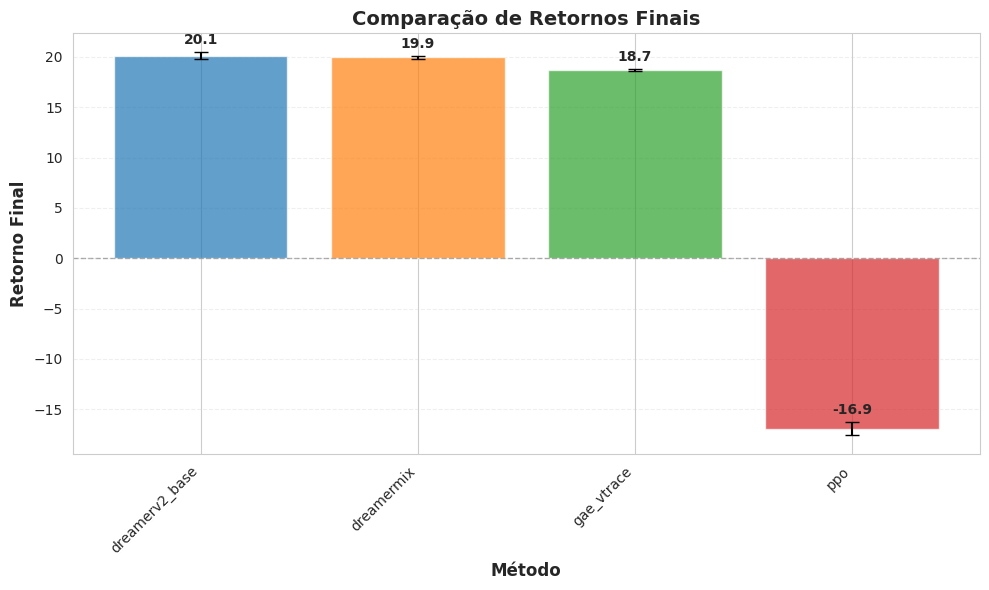

In [38]:
stats_summary = []

for method in df_plot['method'].unique():
    df_method = df_plot[df_plot['method'] == method]
    
    # Pegar os últimos valores (maiores env_steps)
    df_final = df_method[df_method['env_steps'] == df_method['env_steps'].max()]
    
    final_return = df_final['return_mean'].values[0] if len(df_final) > 0 else np.nan
    final_std = df_final['return_std'].values[0] if len(df_final) > 0 else np.nan
    max_return = df_method['return_mean'].max()
    avg_return = df_method['return_mean'].mean()
    final_steps = df_method['env_steps'].max()
    
    stats_summary.append({
        'method': method,
        'final_return': final_return,
        'final_std': final_std,
        'max_return': max_return,
        'avg_return': avg_return,
        'final_steps_M': final_steps / 1e6
    })
    
    print(f"\n{method.upper()}")
    print(f"  Return final: {final_return:.2f} ± {final_std:.2f}")
    print(f"  Return máximo: {max_return:.2f}")
    print(f"  Return médio: {avg_return:.2f}")
    print(f"  Steps finais: {final_steps/1e6:.1f}M")

# Criar DataFrame de resumo
stats_df = pd.DataFrame(stats_summary).sort_values('final_return', ascending=False)

print()
print("RANKING POR RETORNO FINAL")
print()

print(stats_df.to_string(index=False))

# Criar gráfico de barras comparativo
fig, ax = plt.subplots(figsize=(10, 6))

methods = stats_df['method'].values
returns = stats_df['final_return'].values
stds = stats_df['final_std'].values

x_pos = np.arange(len(methods))
bars = ax.bar(x_pos, returns, yerr=stds, capsize=5, alpha=0.7,
              color=[colors.get(m, 'gray') for m in methods])

ax.set_xlabel('Método', fontsize=12, fontweight='bold')
ax.set_ylabel('Retorno Final', fontsize=12, fontweight='bold')
ax.set_title('Comparação de Retornos Finais', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)

# Adicionar valores nas barras
for i, (v, s) in enumerate(zip(returns, stds)):
    ax.text(i, v + s + 0.5, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
output_file = figs_dir / 'comparison_final_returns.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\n✓ Figura salva em: {output_file}")
plt.show()

### 4.4 Gráfico com Intervalo de Confiança 95%

✓ Figura com IC95% salva em: figs/comparison_ci95.png


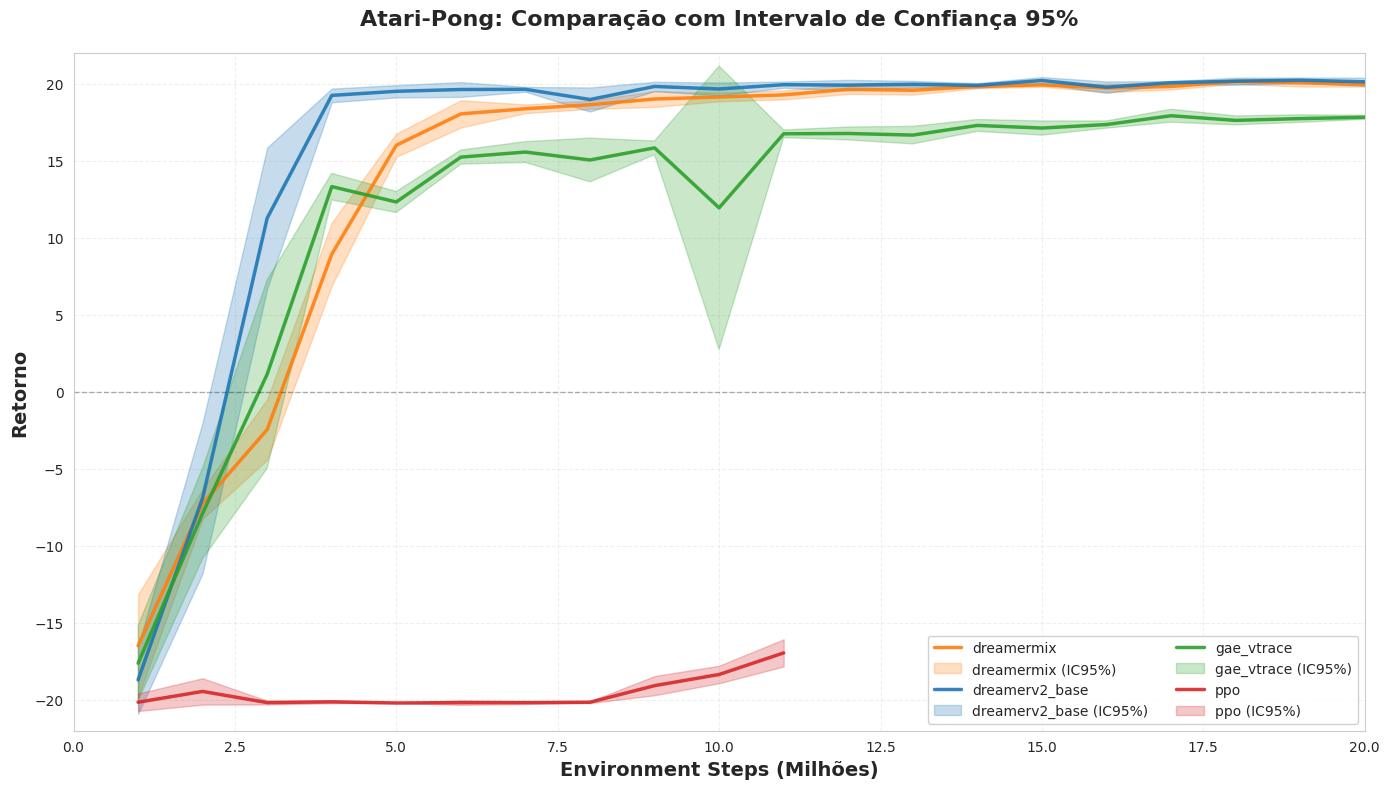


INTERVALO DE CONFIANÇA 95% - ÚLTIMOS VALORES

DREAMERMIX
  Retorno médio: 19.95
  IC95%: [19.80, 20.10]
  Amplitude: ±0.15
  N amostras: 6

DREAMERV2_BASE
  Retorno médio: 20.12
  IC95%: [19.85, 20.38]
  Amplitude: ±0.26
  N amostras: 6

GAE_VTRACE
  Retorno médio: 18.72
  IC95%: [18.64, 18.80]
  Amplitude: ±0.08
  N amostras: 6

PPO
  Retorno médio: -16.95
  IC95%: [-17.83, -16.07]
  Amplitude: ±0.88
  N amostras: 2


In [ ]:
# Calcular Intervalo de Confiança 95% (IC95)
# IC95 = média ± 1.96 × (std / √n)

df_plot_ci = df_plot.copy()

# Calcular IC95 para cada ponto
df_plot_ci['ci95_margin'] = 1.96 * (df_plot_ci['return_std'] / np.sqrt(df_plot_ci['count']))
df_plot_ci['ci95_lower'] = df_plot_ci['return_mean'] - df_plot_ci['ci95_margin']
df_plot_ci['ci95_upper'] = df_plot_ci['return_mean'] + df_plot_ci['ci95_margin']

# Criar figura com IC95
fig, ax = plt.subplots(figsize=(14, 8))

# Plotar cada método com IC95
for method in df_plot_ci['method'].unique():
    df_method = df_plot_ci[df_plot_ci['method'] == method].sort_values('env_steps')
    
    color = colors.get(method, None)
    
    # Linha principal (média)
    ax.plot(df_method['env_steps'] / 1e6, 
            df_method['return_mean'], 
            label=f'{method}', 
            linewidth=2.5,
            color=color,
            alpha=0.9)
    
    # Área sombreada (IC95)
    ax.fill_between(df_method['env_steps'] / 1e6,
                     df_method['ci95_lower'],
                     df_method['ci95_upper'],
                     alpha=0.25,
                     color=color,
                     label=f'{method} (IC95%)')

# Configurações do gráfico
ax.set_xlabel('Environment Steps (Milhões)', fontsize=14, fontweight='bold')
ax.set_ylabel('Retorno', fontsize=14, fontweight='bold')
ax.set_title('Atari-Pong: Comparação com Intervalo de Confiança 95%', fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=10, loc='lower right', framealpha=0.9, ncol=2)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(0, 20)
ax.set_ylim(-22, 22)

# Adicionar linha zero para referência
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)

plt.tight_layout()

# Salvar figura
output_file = figs_dir / 'comparison_ci95.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"✓ Figura com IC95% salva em: {output_file}")

plt.show()

# Mostrar estatísticas de IC95 para o último ponto
print("INTERVALO DE CONFIANÇA 95% - ÚLTIMOS VALORES")

for method in df_plot_ci['method'].unique():
    df_method = df_plot_ci[df_plot_ci['method'] == method]
    df_final = df_method[df_method['env_steps'] == df_method['env_steps'].max()]
    
    if len(df_final) > 0:
        mean = df_final['return_mean'].values[0]
        ci_lower = df_final['ci95_lower'].values[0]
        ci_upper = df_final['ci95_upper'].values[0]
        count = df_final['count'].values[0]
        
        print(f"\n{method.upper()}")
        print(f"  Retorno médio: {mean:.2f}")
        print(f"  IC95%: [{ci_lower:.2f}, {ci_upper:.2f}]")
        print(f"  Amplitude: ±{(ci_upper - mean):.2f}")
        print(f"  N amostras: {count}")

### 4.5 Curva por Episódio

Carregando dados por episódio...

gae_vtrace: 789 episódios
dreamerv2_base: 303 episódios
ppo: 265 episódios
dreamermix: 268 episódios

Total de episódios: 1625
Métodos: ['gae_vtrace' 'dreamerv2_base' 'ppo' 'dreamermix']

Figura por episódio salva em: figs/comparison_by_episode.png


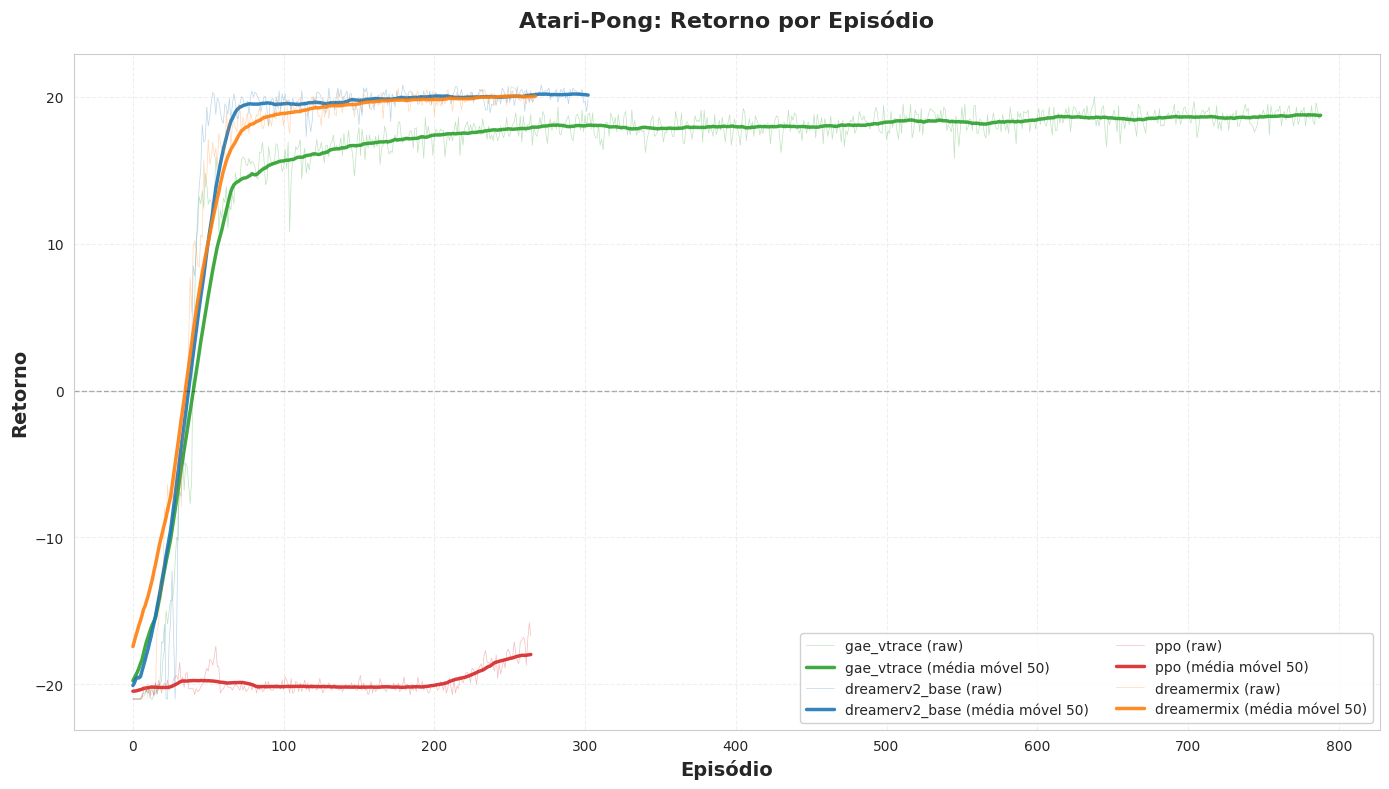

In [42]:
# Carregar métricas por episódio (agent/return sem agregação)
print("Carregando dados por episódio...\n")

episode_data = []

for run_info in runs_data:
    run_id = run_info['run_id']
    experiment_name = run_info['experiment']
    env_id = run_info['env_id']
    
    if experiment_name == 'N/A':
        continue
    
    # Carregar métrica de return por episódio
    run_dir = mlruns_path / run_id
    metric_path = run_dir / 'metrics' / 'agent' / 'return'
    
    if not metric_path.exists():
        print(f"Métrica não encontrada para {experiment_name}")
        continue
    
    # Ler dados do arquivo
    data = read_metric_file(metric_path)
    
    if data:
        df_episode = pd.DataFrame(data)
        df_episode['method'] = experiment_name
        df_episode['episode'] = range(len(df_episode))
        episode_data.append(df_episode)
        print(f"{experiment_name}: {len(df_episode)} episódios")

if episode_data:
    df_episodes = pd.concat(episode_data, ignore_index=True)
    
    print(f"\nTotal de episódios: {len(df_episodes)}")
    print(f"Métodos: {df_episodes['method'].unique()}")
    
    # Plotar curvas por episódio
    fig, ax = plt.subplots(figsize=(14, 8))
    
    for method in df_episodes['method'].unique():
        df_method = df_episodes[df_episodes['method'] == method].sort_values('episode')
        
        color = colors.get(method, None)
        
        # Linha fina com transparência
        ax.plot(df_method['episode'], 
                df_method['value'], 
                label=f'{method} (raw)', 
                linewidth=0.5,
                color=color,
                alpha=0.3)
        
        # Média móvel para suavizar
        window = 50
        df_method['value_smooth'] = df_method['value'].rolling(window=window, center=True, min_periods=1).mean()
        
        ax.plot(df_method['episode'], 
                df_method['value_smooth'], 
                label=f'{method} (média móvel {window})', 
                linewidth=2.5,
                color=color,
                alpha=0.9)
    
    ax.set_xlabel('Episódio', fontsize=14, fontweight='bold')
    ax.set_ylabel('Retorno', fontsize=14, fontweight='bold')
    ax.set_title('Atari-Pong: Retorno por Episódio', fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=10, loc='lower right', framealpha=0.9, ncol=2)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=1)
    
    plt.tight_layout()
    
    output_file = figs_dir / 'comparison_by_episode.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"\nFigura por episódio salva em: {output_file}")
    
    plt.show()
else:
    print("Nenhum dado de episódio encontrado")